In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from matplotlib_venn import venn2
from matplotlib_venn import venn2_unweighted 
import matplotlib.pyplot as plt

### Matching ids between genes and proteins

In [14]:
def matchingProteinsIDs(featureTable):
    #read strain "feature_table"
    featuresDF = pd.read_csv(featureTable, delimiter = "\t")
    OldLocusDF=featuresDF.copy()
    OldLocusDF=OldLocusDF[['locus_tag', 'attributes']]
    OldLocusDF=OldLocusDF.dropna(subset = ["attributes"])
    OldLocusDF['attributes'] = OldLocusDF['attributes'].str.split(',', n=1).str.get(-1)
    OldLocusDF['attributes'] = OldLocusDF['attributes'].str.split('=', n=1).str.get(-1)
    RefSeqIDs=featuresDF.copy()
    RefSeqIDs=RefSeqIDs[['product_accession', 'non-redundant_refseq', 'name', 'symbol', 'locus_tag']]
    RefSeqIDs = RefSeqIDs.T.drop_duplicates().T
    allIDsDF=pd.merge(OldLocusDF, RefSeqIDs, on="locus_tag")
    allIDsDF=allIDsDF.dropna(subset = ["product_accession"])
    allIDsDF=allIDsDF.dropna(subset = ["attributes"])
    allIDsDF['product_accession'] = allIDsDF['product_accession'].str.replace('.','_')
    allIDsDF=allIDsDF.rename(columns = {'locus_tag':'RefSeq_id','attributes':'STITCHid', 'product_accession':'CarveMeID', 'name':'ProteinName'})
    allIDsDF['STITCHid'] = '226186.' + allIDsDF['STITCHid'].astype(str)
    return allIDsDF

In [15]:
MatchProteinIDs=matchingProteinsIDs('GCF_000011065.1_ASM1106v1_feature_table.txt')
MatchProteinIDs

/tmp/ipykernel_33549/1641403634.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  allIDsDF['product_accession'] = allIDsDF['product_accession'].str.replace('.','_')


,RefSeq_id,STITCHid,CarveMeID,ProteinName,symbol
1,BT_RS00005,226186.BT_0001,WP_011107050_1,hypothetical protein,NaN
3,BT_RS00010,226186.BT_0002,WP_009039994_1,hypothetical protein,NaN
5,BT_RS00015,226186.BT_0003,WP_009039993_1,DUF4469 domain-containing protein,NaN
7,BT_RS00020,226186.BT_0004,WP_008647129_1,hypothetical protein,NaN
9,BT_RS00030,226186.BT_0006,WP_011107052_1,hypothetical protein,NaN
...,...,...,...,...,...
9763,BT_RS24270,226186.BT_p548234,WP_005648594_1,recombinase family protein,NaN
9765,BT_RS24275,226186.BT_p548235,WP_011109635_1,Fic family protein,NaN
9767,BT_RS24280,226186.BT_p548236,WP_005648588_1,hypothetical protein,NaN
9769,BT_RS24285,226186.BT_p548237,WP_162303076_1,hypothetical protein,NaN


In [16]:
FastaGenes=list(MatchProteinIDs.STITCHid.unique())

## load Btheta STITCH file "226186.actions.v5.0.tsv.gz"

In [17]:
drug_actions=pd.read_csv('226186.actions.v5.0.tsv.gz', sep='\t', header=0)
# drug_actions

## reduce file to only inhibiting drugs

In [18]:
StitchInhibit=drug_actions.copy()
StitchInhibit=StitchInhibit[(StitchInhibit['mode'] == 'inhibition') & (StitchInhibit['action'] == 'inhibition')]
StitchInhibit=StitchInhibit[(StitchInhibit['item_id_a'].str.contains('CID')) & (StitchInhibit['a_is_acting'] == 't')]
StitchInhibit['CIDno'] = StitchInhibit['item_id_a'].str.replace("CIDs", '')
StitchInhibit['CIDno'] = StitchInhibit['CIDno'].str.replace("CIDm", '')
# StitchInhibit

#### this means that when a drug is inhibiting a gene, both "mode" and "action" are "inhibiting"

## get drugs selected from papers

In [19]:
PaperNeuro=pd.read_excel('MaierEtAl2018_AllOtherDrugs.xlsx', index_col=0 )
PaperNeuro['CIDno'] = PaperNeuro['CID'].str.replace("CIDs", '')
# PaperNeuro

# See if all drugs selected are in STITCH files

In [ ]:
#neuro CIDs list
uniqueNeuroCIDs=PaperNeuro.CIDno.unique()
print('unique prestwicks',len(list(PaperNeuro.prestwickID.unique())))
uniqueNeuroCIDs=list(uniqueNeuroCIDs)
#stitch inhibit CID list
StitchInhibit=StitchInhibit[StitchInhibit['item_id_b'].isin(FastaGenes)]
uniqueStitchInhibitCIDs=StitchInhibit.CIDno.unique()
uniqueStitchInhibitCIDs=list(uniqueStitchInhibitCIDs)

#Stitch dataframe containing neuro drugs
NeuroStitchInhibit=StitchInhibit[StitchInhibit['CIDno'].isin(uniqueNeuroCIDs)]
UniqueNeuroStitchInhibit=list(NeuroStitchInhibit.CIDno.unique())
print(len(UniqueNeuroStitchInhibit), 'out of', len(list(uniqueNeuroCIDs)), 'unique neuroactive drug CIDs, have STITCH inhibiting information')
# NeuroStitchInhibit

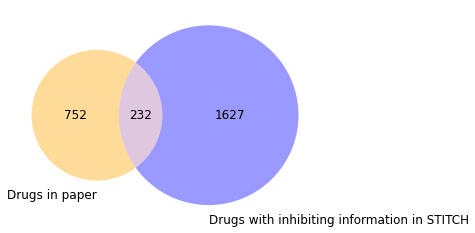

In [21]:
firstVenn=venn2([set(uniqueNeuroCIDs), set(uniqueStitchInhibitCIDs)],set_labels=('Drugs in paper', 'Drugs with inhibiting information in STITCH'), set_colors=('orange', 'blue'))
for text in firstVenn.subset_labels:
    text.set_fontsize(12)

### get list of drugs that have the same CID but more than one prestwick id, thus names

In [ ]:
drugsSameCID=[]
for cid in uniqueNeuroCIDs:
    correspRows=PaperNeuro.loc[PaperNeuro['CIDno'] == cid]
    if len(correspRows.index) > 1: #if there are cids with more than 1 row, i.e., that have different names, get the prestwickID
        prestwickIDs=correspRows['prestwickID'].tolist()
        print('cid of the drug', cid,'/', 'prestwick cids', prestwickIDs)
        drugsSameCID.append(cid)
# drugsSameCID

In [ ]:
#number of drugs with same CID that have STITCH info.
drugsSameCIDset=set(drugsSameCID)
uniqueStitchInhibitCIDsset=set(UniqueNeuroStitchInhibit)

intersection = drugsSameCIDset.intersection(uniqueStitchInhibitCIDsset)
intersection

In [ ]:
STITCH_PapersInfo=pd.merge(PaperNeuro, NeuroStitchInhibit, on="CIDno")
# STITCH_PapersInfo

In [10]:
STITCH_PapersInfo=STITCH_PapersInfo.drop(columns=['CID', 'mode', 'action', 'a_is_acting'])
print(len(list(STITCH_PapersInfo.CIDno.unique())))

234


In [ ]:
# STITCH_PapersInfo

### read excel of matching ids between genes and proteins

In [7]:
BthetaProteinIds=MatchProteinIDs.copy()
BthetaProteinIds=BthetaProteinIds.drop(columns=["RefSeq_id"])
# BthetaProteinIds

In [ ]:
#Venn Diagram
# ProteinsStitchNpaper=set(list(STITCH_PapersInfo.item_id_b.unique()))
# ProteinsFasta=set(list(MatchProteinIDs.STITCHid.unique()))
# secondVenn=venn2([ProteinsFasta, ProteinsStitchNpaper],set_labels=('ProteinsFASTA', 'ProteinsStitchNpaper'), set_colors=('orange', 'blue'))
# for text in secondVenn.subset_labels:
#     text.set_fontsize(12)

In [15]:
STITCH_PapersInfo=STITCH_PapersInfo.rename(columns = {'item_id_b':'STITCHid'})
# STITCH_PapersInfo

In [16]:
proteinMatching=pd.merge(BthetaProteinIds, STITCH_PapersInfo, on="STITCHid")
proteinMatching=proteinMatching.sort_values(by=['CIDno'])
proteinMatching.drop_duplicates(subset=['STITCHid', 'CarveMeID', 'prestwickID', 'CIDno'], keep="first", inplace=True)
# proteinMatching=proteinMatching[proteinMatching['targetSpecies'] != "not a drug"]
proteinMatching

,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
1068,226186.BT_2047,WP_008761063_1,thymidylate synthase,NaN,Prestw-738,Folinic acid calcium salt,V03AF03 V03AF04 V03AF06,human,00000143,CIDm00000143,690
483,226186.BT_0555,WP_008765068_1,amidophosphoribosyltransferase,NaN,Prestw-356,Adenosine 5'-monophosphate monohydrate,-,not a drug,00000224,CIDm00000224,725
1827,226186.BT_4582,WP_008764741_1,amidophosphoribosyltransferase,NaN,Prestw-356,Adenosine 5'-monophosphate monohydrate,-,not a drug,00000224,CIDm00000224,725
751,226186.BT_1221,WP_008763420_1,glucose-6-phosphate dehydrogenase,zwf,Prestw-440,Epiandrosterone,A14AA,human,00000225,CIDm00000225,564
752,226186.BT_1221,WP_008763420_1,glucose-6-phosphate dehydrogenase,zwf,Prestw-697,3-alpha-Hydroxy-5-beta-androstan-17-one,A14AA,human,00000225,CIDm00000225,564
...,...,...,...,...,...,...,...,...,...,...,...
898,226186.BT_1438,WP_016267165_1,MFS transporter,NaN,Prestw-211,Piroxicam,M01AC01 M02AA07 S01BC06,human,23690938,CIDm23690938,380
1655,226186.BT_3606,WP_008767094_1,sugar porter family MFS transporter,NaN,Prestw-211,Piroxicam,M01AC01 M02AA07 S01BC06,human,23690938,CIDs23690938,380
120,226186.BT_0436,WP_008766062_1,sugar porter family MFS transporter,NaN,Prestw-211,Piroxicam,M01AC01 M02AA07 S01BC06,human,23690938,CIDm23690938,380
854,226186.BT_1383,WP_011107747_1,aldo/keto reductase,NaN,Prestw-785,Dicumarol,B01AA01,human,25201794,CIDm25201794,434


In [17]:
print('number of unique prestwick IDs', len(list(proteinMatching.prestwickID.unique())))

number of unique prestwick IDs 242


In [19]:
# proteinMatching.to_excel("Btheta_2018AllOtherDrugsInhibit.xlsx")